In [1]:
%load_ext tikzmagic

In [2]:
import networkx as nx

# Sketches towards Solution Concepts for Iterated MACIDs

_Sebastian Benthall, April 11, 2022_

This notebook poses a problem for MACID theory that considers the case of iterated MACID games.

These games have a repeating structure that suggests a temporal ordering. They also may have multiple utility nodes per agent per game. The hunch is that there is something about the temporal metaphor, or the structure of the utility function such that it unfolds in stages of activity, that allows for further equilibrium refinement beyond those yet proposed (such as Nash Equilibrium or SPE).

This notebook will begin with a sample problem that is motivated by current issues in macroeconomic theory and technology policy. 

## Transition Equations

Simplifying

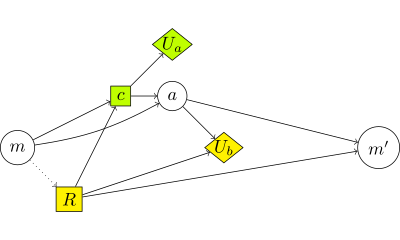

In [3]:
%%tikz -f svg
\usetikzlibrary{shapes}

\node[shape=circle,draw=black] (m) at (-1,0) {$m$};

\node[shape=rectangle,draw=black, fill=lime] (c) at (1,1) {$c$};

\node[shape=circle,draw=black] (a) at (2,1) {$a$};

\node[shape=circle,draw=black] (m_) at (6,0) {$m'$};

\node[shape=diamond,draw=black, aspect=1.25, inner sep=0pt, fill=lime] (U_a) at (2,2) {$U_a$};
                                         
\node[shape=rectangle,draw=black, fill=yellow] (R) at (0,-1) {$R$};
\node[shape=diamond,draw=black, aspect=1.25, inner sep=0pt, fill=yellow] (U_b) at (3,0) {$U_b$};


\path [->] (m) edge node[left] {} (c);

\path [->, style=dotted ] (m) edge node[left] {} (R);

\path [->] (R) edge node[left] {} (c);
                                              
\path [->] (c) edge node[left] {} (U_a);


\path [->] (c) edge node[left] {} (a);
\path [->] (m) edge [bend right = 10] node[left] {} (a);
                                              
\path [->] (a) edge node[left] {} (U_b);      
\path [->] (R) edge node[left] {} (U_b);                                            

\path [->] (a) edge node[left] {} (m_);
\path [->] (R) edge node[left] {} (m_);


The transition equations are:

\begin{eqnarray*}
a_t &=& m_t - c_t, \\
a_t &\geq& \text{$\hat{a}$}, \\
m_{t+1} &=& R a + y,\\
U_a(c) &=& \frac{c^{1-\rho}}{1-\rho} \\
U_b(a, \eta, R) &=& a (- R)
\end{eqnarray*}

We consider the edge between $m$ and $R$ as optional. We are also unspecific at this point whether the game has perfect recall, absent-mindedness, etc.

## Bellman Equations

This model is distinguished by two features:

- Serial decisions - both $R$ and $c$ are control variables
- Multi-agent - there are two agents and two utility functions (and two discount factors); the agents each operate one control variable.

In a single period of the game, there are two optimizations. The consumer optimizes:

$$v^a_t(m_t) = \max_{c_t} U_a(c_t) + \beta_a(1-D_{t+1})  \mathbb{E}_{t} \left[ (v^a_{t+1} (m_{t+1}) \right]$$

The banker optimizes:

$$v^b_t(m_t) = \max_{R_t}  \mathbb{E}\left[ U_b(m_t - c_t, \eta, R) \right] + \beta_b(1-D_{t+1}) \mathbb{E}_{t} \left[ v^b_{t+1} (m_{t+1}) \right]$$

## Repeating the game

We can expand this game to some number of finite stages programmatically.

In this notebook we will look at this game itereated to 2 stages, as we explore the space of solution concepts applicable in these problems.

In [103]:
def repeat_macid(macid, linked_decisions = False):
    edges = list(macid.edges)
    agent_decisions = macid.agent_decisions
    agent_utilities = macid.agent_utilities
    
    edges2 = edges.copy() + [(edge[0] + "`", edge[1] + "`") for edge in edges.copy()]
    
    agent_decisions2 = {key : agent_decisions[key].copy() + [n + "`" for n in agent_decisions[key].copy()]
                        for key
                        in agent_decisions}
    agent_utilities2 = {key : agent_utilities[key].copy() + [n + "`" for n in agent_utilities[key].copy()]
                        for key
                        in agent_utilities}
    
    if linked_decisions:
        for key in agent_decisions:
            for dec in agent_decisions[key]:
                # these are the original game's decisions
                edges2 = edges2 + [(dec, dec + "`")]
    
    return pycid.MACID(
        edges2,
        agent_decisions=agent_decisions2,
        agent_utilities=agent_utilities2,
    )

## Case A: Informed Bank, Totally Ordered

A key contribution of the theory of MACID's is that the topology of dependencies in a Multi-Agent Causal Influence Diagram (which the above problem implies) can be used to order subproblems based on which decisions are relevant to which other decisions.

The _r-reachability_ relation induces a partial order on decision nodes.

In the version fo this problem in which the bank knows the market resources of the consumer (there is an edge from $m$ to $R$)

In [104]:
import pycid

In [105]:
macid = pycid.MACID([
        ('m', 'c'),
        ('m', 'R'), ## Optional - Bank knows assets
        ('R', 'c'),
        ('c', 'U_a'),
        ('c', 'a'),
        ('m', 'a'),
        ('R', 'U_b'),
        ('a', 'U_b'),
        ('a', 'm`'),
        ('R', 'm`'),
        ],
        # specifies each agent's decision and utility nodes.
        agent_decisions={1: ['c'], 2: ['R']},
        agent_utilities={1: ['U_a'], 2: ['U_b']},
)

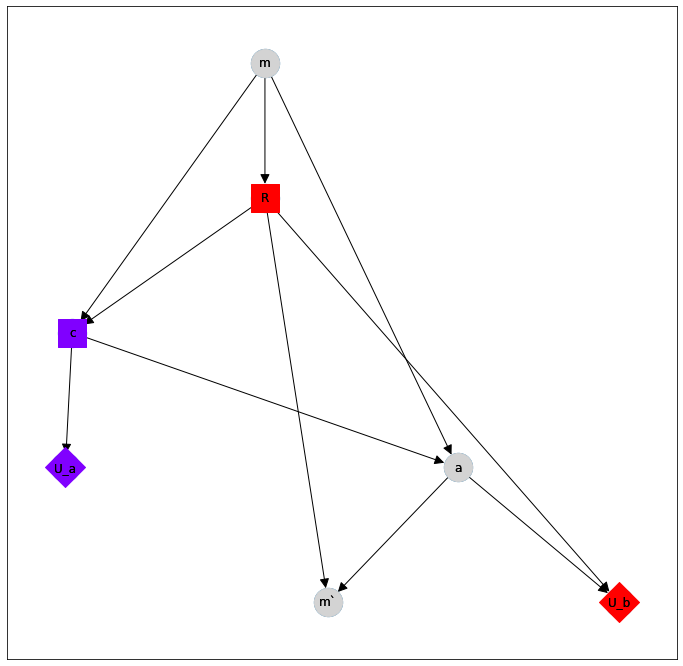

In [106]:
macid.draw(layout = lambda G: nx.drawing.nx_pydot.graphviz_layout(G, prog='dot'))

In [107]:
macid2 = repeat_macid(macid, linked_decisions = False)

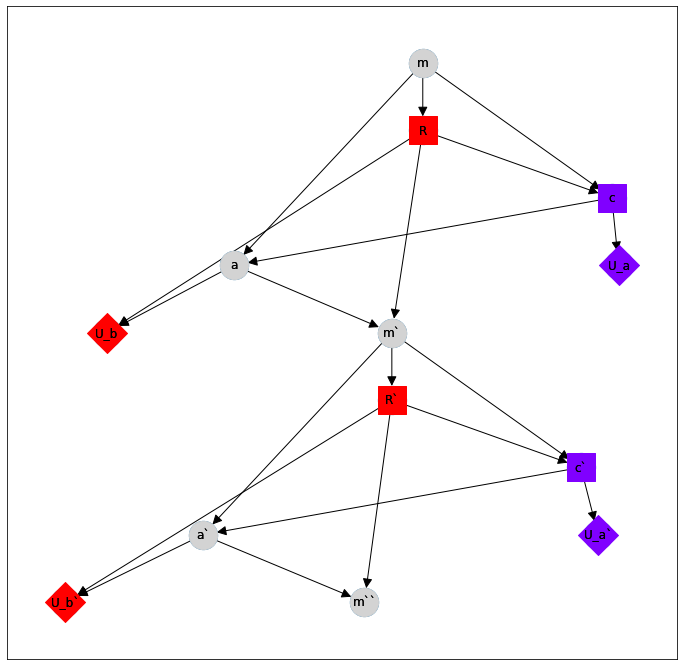

In [108]:
macid2.draw(layout = lambda G: nx.drawing.nx_pydot.graphviz_layout(G, prog='dot'))

In [109]:
macid2.nodes

NodeView(('m', 'c', 'R', 'a', 'U_a', 'U_b', 'm`', 'c`', 'R`', 'a`', 'U_a`', 'U_b`', 'm``'))

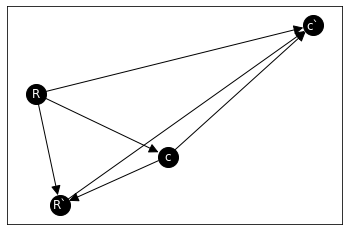

In [110]:
pycid.RelevanceGraph(macid2).draw()

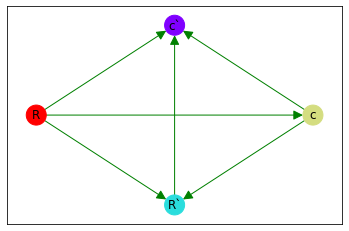

In [111]:
pycid.RelevanceGraph(macid2).draw_sccs()

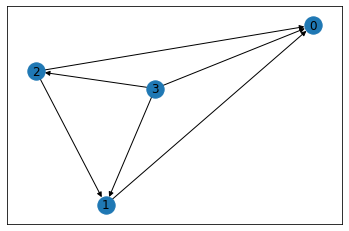

In [112]:
pycid.CondensedRelevanceGraph(macid2).draw()

In this case, the problem can be solved straightforwardly using backwards induction.

## Case B: Uninformed Bank, Subgame Collapse

Now consider the variation in which the bank does not know the market resources of the consumer.

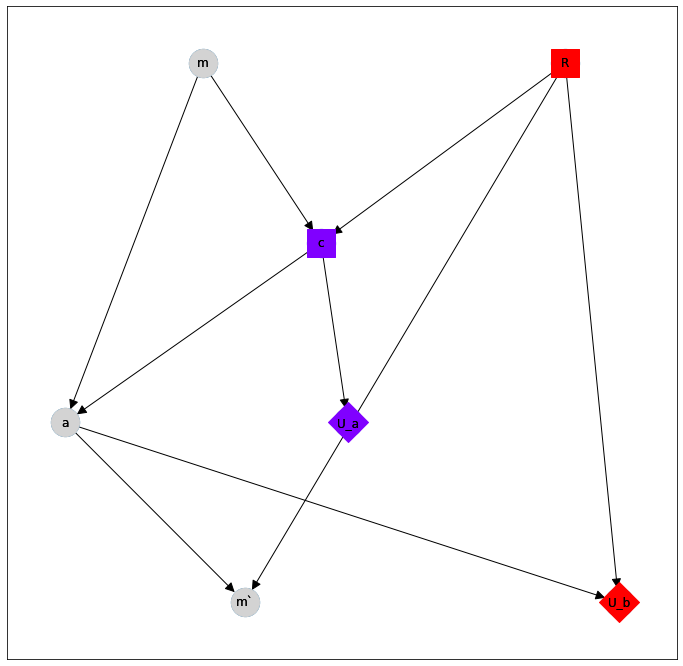

In [122]:
macid = pycid.MACID([
        ('m', 'c'),
        #('m', 'R'), ## Optional - Bank knows assets
        ('R', 'c'),
        ('c', 'U_a'),
        ('c', 'a'),
        ('m', 'a'),
        ('R', 'U_b'),
        ('a', 'U_b'),
        ('a', 'm`'),
        ('R', 'm`'),
        ],
        # specifies each agent's decision and utility nodes.
        agent_decisions={1: ['c'], 2: ['R']},
        agent_utilities={1: ['U_a'], 2: ['U_b']},
)

macid.draw(layout = lambda G: nx.drawing.nx_pydot.graphviz_layout(G, prog='dot'))

In [117]:
macid2 = repeat_macid(macid, linked_decisions = False)

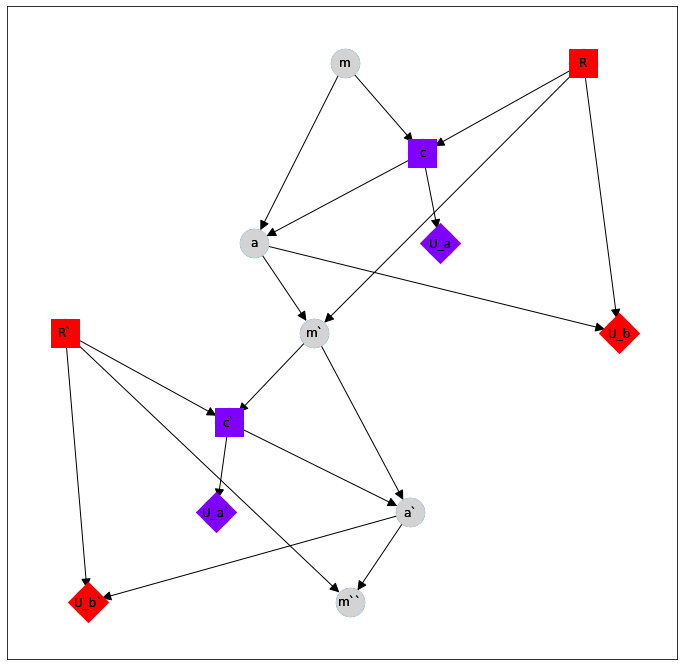

In [118]:
macid2.draw(layout = lambda G: nx.drawing.nx_pydot.graphviz_layout(G, prog='dot'))

In this case, the strategic relevance of the decisions is much more entangled, making the problem harder to solve.

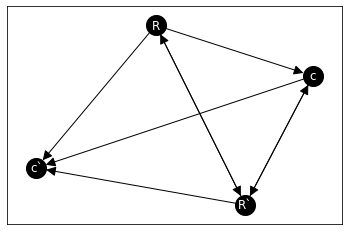

In [119]:
pycid.RelevanceGraph(macid2).draw()

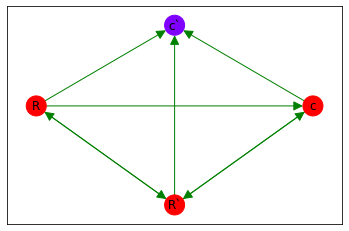

In [120]:
pycid.RelevanceGraph(macid2).draw_sccs()

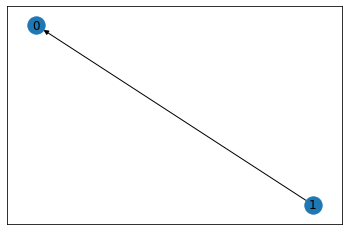

In [121]:
pycid.CondensedRelevanceGraph(macid2).draw()

While this is a correct result from the perspective of Koller and Milch and more recent theoretical results, it is disappointing from the view of the analyst, as this problem is no long as easy to solve.

The open question is whether there is a more refined solution concept that can prune the solution space more.

A number of aspects of the problem suggest that this improvement may be possible:
 - There is an information bottleneck at $m`$
 - The agents each control two decision nodes, and so might be able to constrain their own internal strategic logic.
 - There is a topological order to the utility nodes -- utility isn't just a matter of getting to "the end" of the game.

## Case C: Uninformed with Recall

One move that could introduce structure and simplify the problem is recall.

What if agents know about the decision they may in the previous stage?

In [123]:
macid2.decs_in_each_maid_subgame()

[{'c`'}, {'R', 'R`', 'c', 'c`'}]

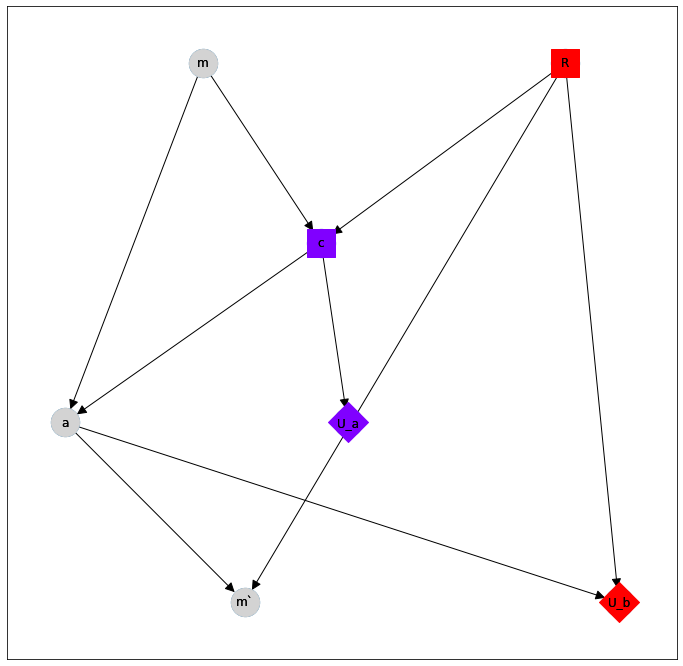

In [124]:
macid = pycid.MACID([
        ('m', 'c'),
        #('m', 'R'), ## Optional - Bank knows assets
        ('R', 'c'),
        ('c', 'U_a'),
        ('c', 'a'),
        ('m', 'a'),
        ('R', 'U_b'),
        ('a', 'U_b'),
        ('a', 'm`'),
        ('R', 'm`'),
        ],
        # specifies each agent's decision and utility nodes.
        agent_decisions={1: ['c'], 2: ['R']},
        agent_utilities={1: ['U_a'], 2: ['U_b']},
)

macid.draw(layout = lambda G: nx.drawing.nx_pydot.graphviz_layout(G, prog='dot'))

In [125]:
macid2 = repeat_macid(macid, linked_decisions = True)

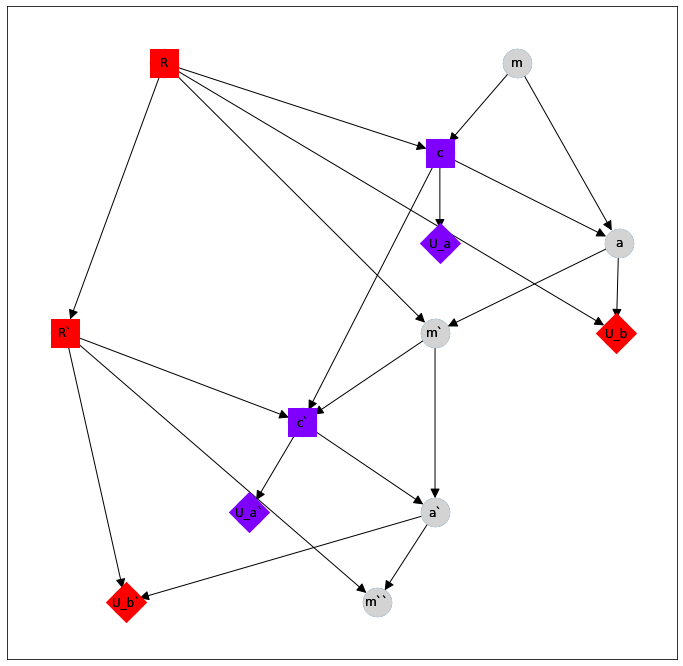

In [126]:
macid2.draw(layout = lambda G: nx.drawing.nx_pydot.graphviz_layout(G, prog='dot'))

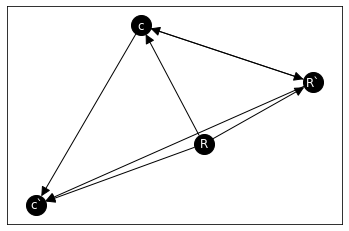

In [127]:
pycid.RelevanceGraph(macid2).draw()

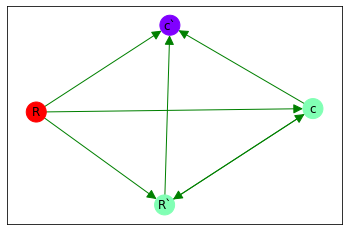

In [128]:
pycid.RelevanceGraph(macid2).draw_sccs()

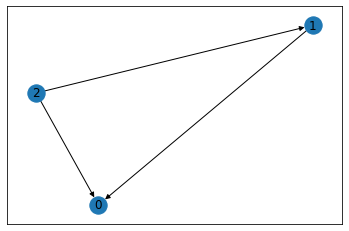

In [129]:
pycid.CondensedRelevanceGraph(macid2).draw()

In this case, addition some recall simplified the problem somewhat by ordering the r-reachability of the decision nodes of each individual agent, and in particular the moves of the bank.

# Observations

- It feels surprising that so much of the relevance structure is lost in Case B. The hunch is that some further solution concept refinement can narrow the space of solutions, perhaps by eliminating non-credible threats.
- Recall has the effect of ordering the decisions made by a single player. Can this ordering be introduced in cases without recall?
- In the full generality of MAIMs for any MAID, it may be possible to come up with parameterizations in which the game theoretic complexity of Case B is well-motivated. What additional assumptions are necessary for the game to be simplified by, say, the information bottleneck at $m`$?